In [1]:
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


In [2]:
import surp
from surp import gce_math as gcem
import arya

from surp import subgiants

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
data_dir = surp._globals.DATA_DIR

# GALAH

see https://www.galah-survey.org/dr3/using_the_data/.

In [4]:
galah_all = Table.read(f"{data_dir}/GALAH_DR3_main_allstar_v2.fits", format="fits", memmap=True)

In [5]:
# recommended cuts in documentation
mask = galah_all["flag_sp"] == 0
mask &= galah_all["flag_fe_h"] == 0
mask &= galah_all["snr_c3_iraf"] > 30


mask &= ~np.isnan(galah_all["teff"])
mask &= ~np.isnan(galah_all["logg"])
mask &= galah_all["e_logg"] < 0.5
mask &= galah_all["e_teff"] < 200


df = galah_all[mask].to_pandas()

df["MG_H"] = df["Mg_fe"] + df["fe_h"]
df["C_MG"] = df["C_fe"] - df["Mg_fe"] 
df["C_O"] = df["C_fe"] - df["O_fe"] 

df["O_H"] = df["O_fe"] + df["fe_h"]
df["MG_O"] = df["O_fe"] - df["Mg_fe"]

df["FE_H"] = df["fe_h"]
df["MG_FE"] = df["Mg_fe"]


df["LOGG"] = df["logg"]
df["TEFF"] = df["teff"]

galah = df

In [6]:
len(galah_all)

588571

In [7]:
len(galah)

323420

In [8]:
# make sure these things exist

abund_mask = galah["LOGG"] >= 3.5

abund_mask &= ~np.isnan(galah["C_MG"])
abund_mask &= ~np.isnan(galah["MG_FE"])
abund_mask &= ~np.isnan(galah["FE_H"])
abund_mask &= galah["flag_C_fe"] == 0
abund_mask &= (galah["flag_O_fe"] == 0) | (galah["flag_Mg_fe"] == 0)

galah_good = galah[abund_mask]


In [9]:
print(len(galah_good))

102016


In [10]:
coords = [
    (3.5, 4800),
    (3.8, 4875),
    (4.0, 5300),
    (3.6, 5600),
    (3.5, 5250),
    (3.5, 4800)
]
y = [c[0] for c in coords]
x = [c[1] for c in coords]

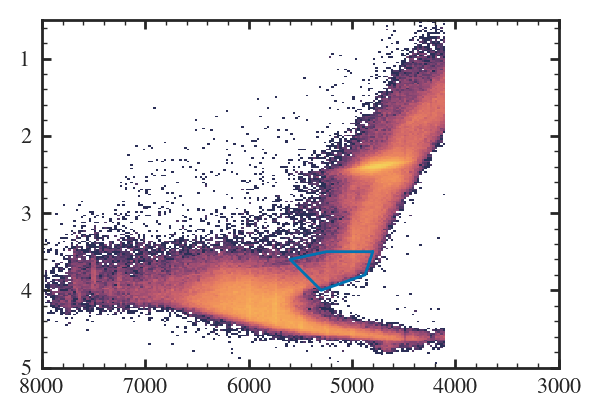

In [11]:
plt.hist2d(galah["TEFF"], galah["LOGG"], 200, 
           range=[[3000, 8000], [0.5, 5]], norm=mpl.colors.LogNorm())
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.plot(x, y)

## error histograms

Text(0.5, 0, 'logg err')

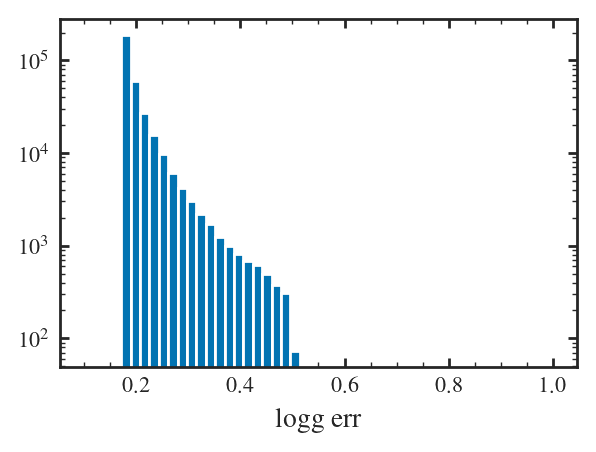

In [12]:
plt.hist(galah["e_logg"], 50, range=(0.1, 1), log=True);
plt.xlabel("logg err")

Text(0.5, 0, 'err Teff')

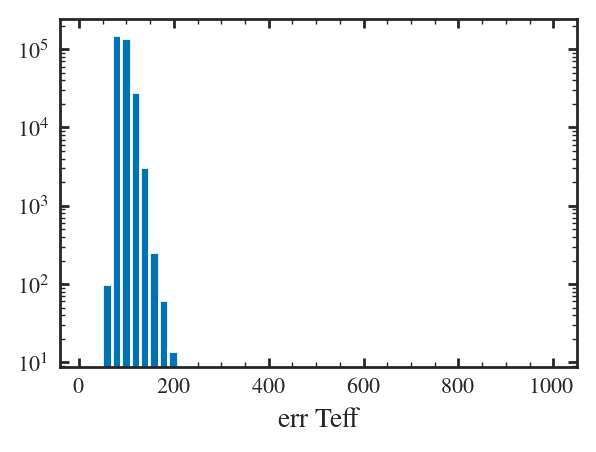

In [13]:
plt.hist(galah["e_teff"], 50, range=(10, 1000), log=True);
plt.xlabel("err Teff")

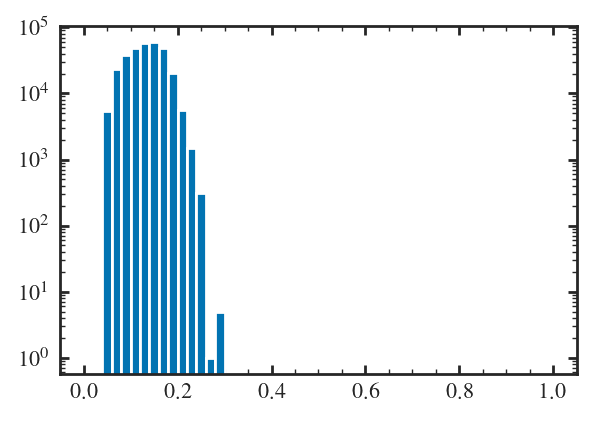

In [14]:
plt.hist(galah["e_O_fe"], 50, range=(0, 1), log=True);

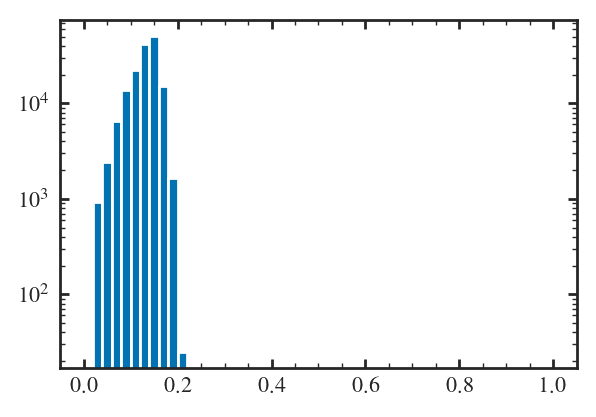

In [15]:
plt.hist(galah["e_C_fe"], 50, range=(0, 1), log=True);

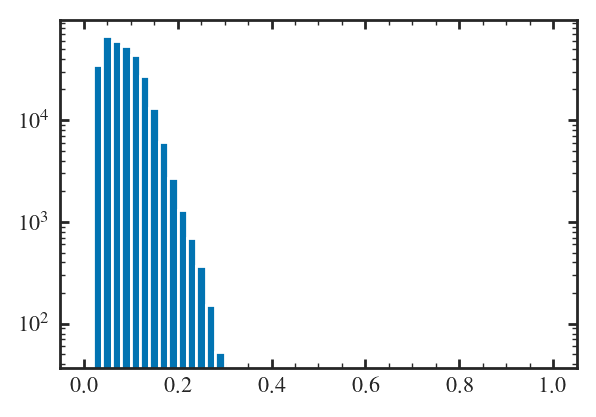

In [16]:
plt.hist(galah["e_Mg_fe"], 50, range=(0, 1), log=True);

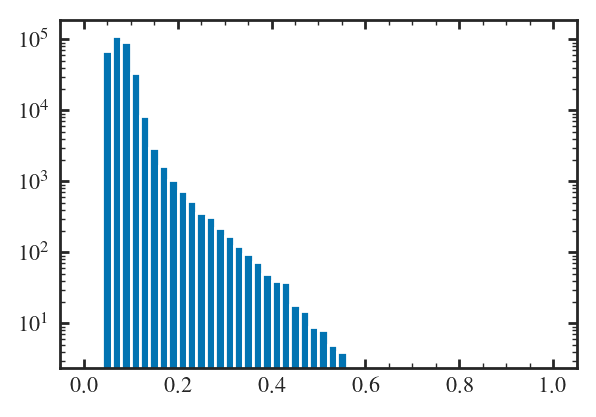

In [17]:
plt.hist(galah["e_fe_h"], 50, range=(0, 1), log=True);

## abundance plots

In [18]:
def plot_ab(df, x, y):
    plt.hist2d(df[x], df[y], 100, range=[[-1, 1], [-1, 1]], norm=mpl.colors.LogNorm())
    arya.plotting.medianplot(df, x, y, numbins=25, color="k")
    plt.xlabel(x.replace("_", "/"))
    plt.ylabel(y.replace("_", "/"))

In [19]:

Nb = 30
bins = np.linspace(-1, 0.6, Nb)
hist = np.digitize(df["FE_H"], bins)

Nc = np.zeros(Nb)

h = np.zeros(Nb)
for b in range(Nb):
    filt = hist == b
    
    Nc[b] = np.sum(~np.isnan(df["C_fe"][filt]))
    h[b] = np.sum(filt)
    


In [20]:
df["C_meas"] = ~np.isnan(df["C_fe"])

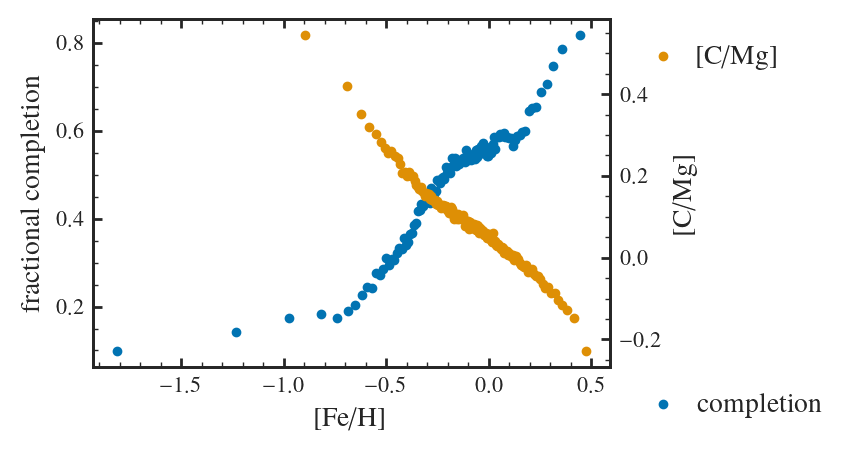

In [21]:
fig, ax = plt.subplots() 
ax_twin = ax.twinx() 

plt.sca(ax)
#plt.plot(bins, Nc/h)
plt.ylabel('fractional completion')
plt.xlabel("[Fe/H]")
arya.medianplot(df, "FE_H", "C_meas", binsize=3000, stat="mean",  errorbar=None, label="completion")

plt.sca(ax_twin)
arya.medianplot(df, "FE_H", "C_MG", binsize=1000, errorbar=None, label="[C/Mg]", color=arya.style.COLORS[1])
plt.ylabel("[C/Mg]")

plt.sca(ax)
plt.legend(loc=2, bbox_to_anchor=(1, 0))
plt.sca(ax_twin)
plt.legend(loc=2, bbox_to_anchor=(1, 1))

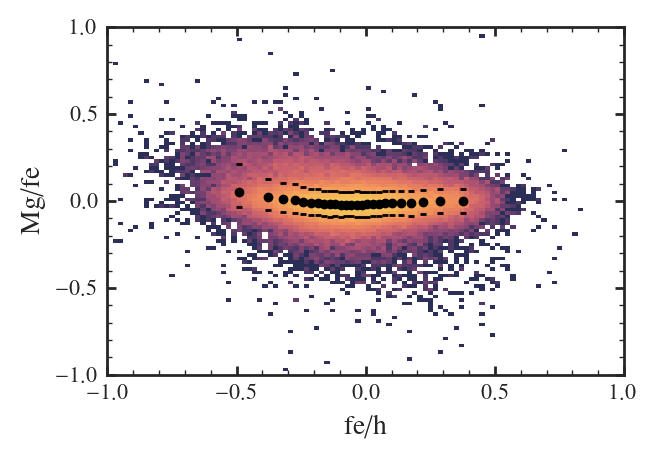

In [22]:
plot_ab(galah_good, "fe_h", "Mg_fe")

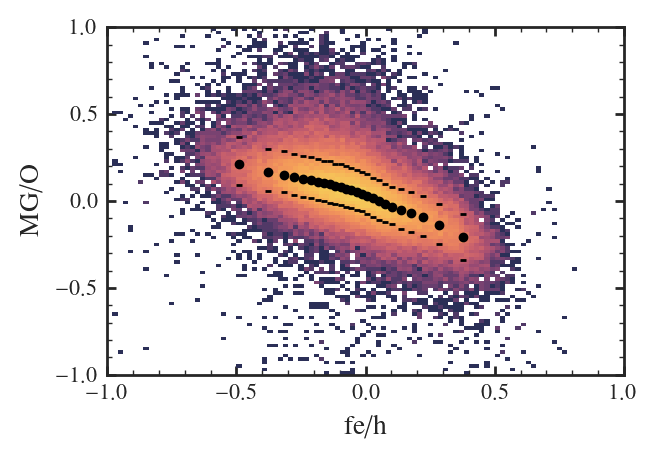

In [23]:
plot_ab(galah_good, "fe_h", "MG_O")

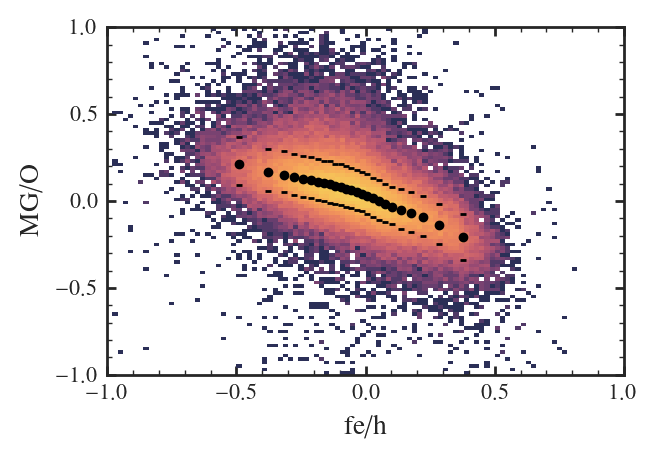

In [24]:
plot_ab(galah_good, "fe_h", "MG_O")

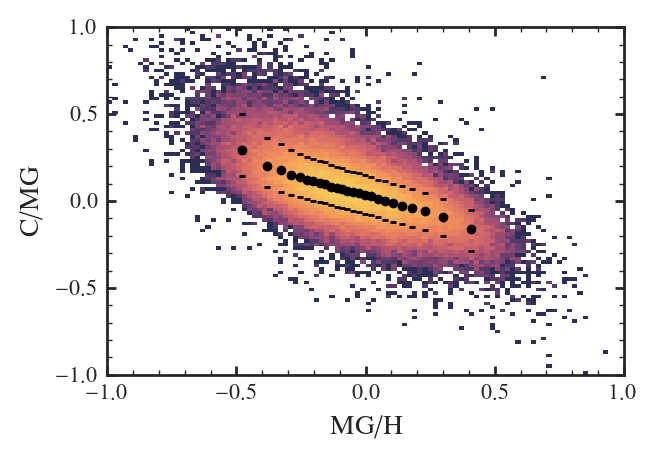

In [25]:
plot_ab(galah_good, "MG_H", "C_MG")

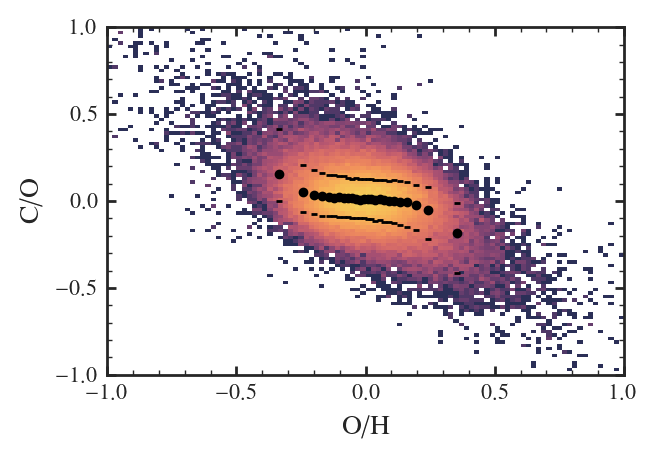

In [26]:
plot_ab(galah_good, "O_H", "C_O")

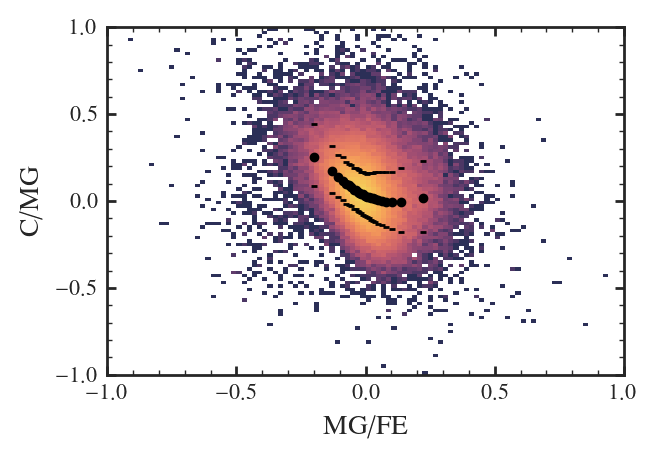

In [27]:
plot_ab(galah_good, "MG_FE", "C_MG")

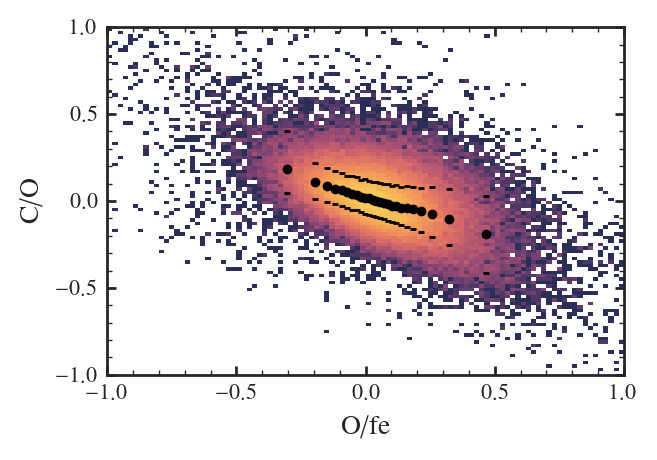

In [28]:
plot_ab(galah_good, "O_fe", "C_O")

In [29]:
galah_good.to_csv("galah_dwarfs.csv")

# GaiaESO
Can find data and docs here https://www.eso.org/sci/publications/announcements/sciann17497.html

In [30]:
gaiaeso_all = Table.read(f"{data_dir}/gaiaeso.fits", format="fits", memmap=True)

Quality cuts

In [31]:
sflags = pd.Series(gaiaeso_all["SFLAGS"]).str.decode("utf-8")

quality_mask = ~sflags.str.contains("SNR")
quality_mask &= ~sflags.str.contains("SRP")
quality_mask &= ~sflags.str.contains("BIN")
quality_mask &= ~sflags.str.contains("SSA")
quality_mask &= ~sflags.str.contains("IPA")
quality_mask &= ~sflags.str.contains("PSC")
quality_mask &= ~sflags.str.contains("EML") # emission line

quality_mask &= gaiaeso_all["E_LOGG"] < 0.5
quality_mask &= gaiaeso_all["E_TEFF"] < 200


gaiaeso = gaiaeso_all[quality_mask.values].to_pandas()

In [32]:
print(len(gaiaeso_all))
print(len(gaiaeso))

114324
52385


In [33]:
def combine(*cols):
    tot = 0
    for col in cols:
        tot += np.where(np.isnan(col), 0, 10**col)
        
    return np.log10(tot)
    return np.where(tot <= 0, np.NaN, np.log10(tot / len(cols)))

In [34]:

gso = gaiaeso
logg = gso["LOGG"]
teff = gso["TEFF"]


eps_c = combine(gso["C1"], gso["C2"], gso["C3"], gso["C_C2"])
gso["C_H"] = gcem.eps_to_brak(eps_c, "C")

eps_o = combine(gso["O1"], gso["O2"])
gso["O_H"] = gcem.eps_to_brak(eps_o, "O")

eps_mg = combine(gso["MG1"], gso["MG2"])
gso["MG_H"] = gcem.eps_to_brak(eps_mg, "mg")

c_err = combine(gso["E_C1"], gso["E_C2"], gso["E_C3"], gso["E_C_C2"])
o_err = combine(gso["E_O1"], gso["E_O2"])
mg_err = combine(gso["E_MG1"], gso["E_MG2"])
fe_err = gso.E_FEH

gso["FE_H"] = gso.FEH


gso["MG_FE"] = gso.MG_H - gso.FE_H
gso["C_MG"] = gso.C_H - gso.MG_H

gso["FE_H_ERR"] = fe_err
gso["MG_H_ERR"] = mg_err + fe_err 
gso["MG_FE_ERR"] = mg_err

gso["C_MG_ERR"] = c_err + fe_err 


gaiaeso = gso

/tmp/slurmtmp.28578868/ipykernel_258914/1584914198.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(tot)
/tmp/slurmtmp.28578868/ipykernel_258914/1584914198.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(tot)
/tmp/slurmtmp.28578868/ipykernel_258914/1584914198.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(tot)
/tmp/slurmtmp.28578868/ipykernel_258914/1584914198.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(tot)


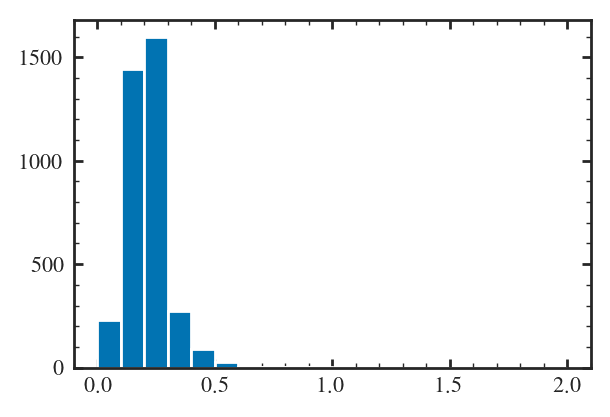

In [35]:
plt.hist(gso["C_MG_ERR"], range=(0, 2), bins=20);

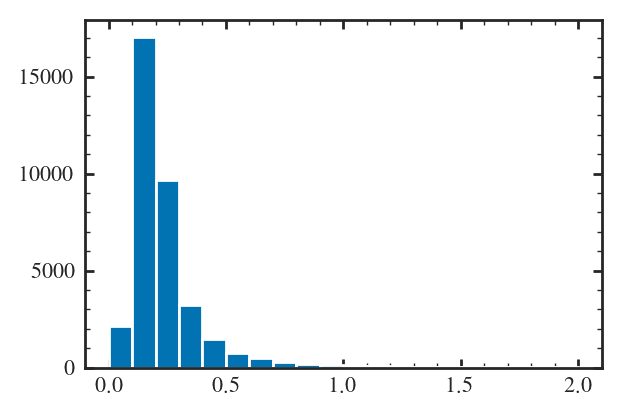

In [36]:
plt.hist(gso["MG_H_ERR"], range=(0, 2), bins=20);

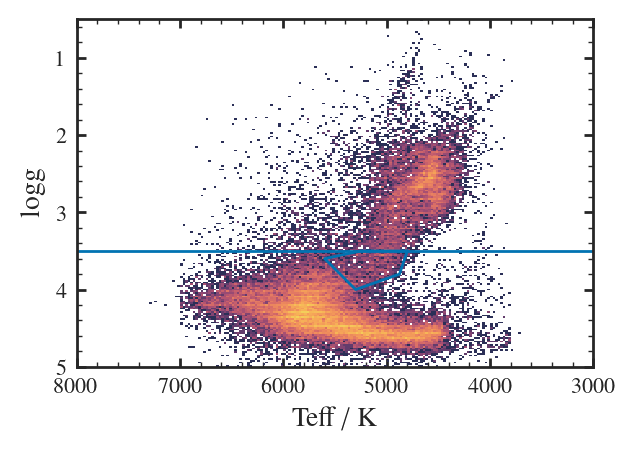

In [37]:
plt.hist2d(gaiaeso["TEFF"], gaiaeso["LOGG"], 200, 
           range=[[3000, 8000], [0.5, 5]], norm=mpl.colors.LogNorm())
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.plot(x, y)
plt.xlabel("Teff / K")
plt.ylabel("logg")
plt.axhline(3.5)

In [38]:
logg = gaiaeso.LOGG
teff = gaiaeso.TEFF

mask = ~np.isnan(logg)
mask &= ~np.isnan(teff)

mask &= logg >= 3.5
# mask &= logg <= 0.004*teff - 15.7
# mask &= logg <= 0.000706*teff + 0.36
# mask &= logg <= -0.0015 * teff + 12.05
# mask &= logg >= 0.0012*teff - 2.8


mask &= gaiaeso.MG_H_ERR > 0
#mask &= gaiaeso.C_MG_ERR > 0

subgiant_mask = np.copy(mask)


In [39]:
mask_abund = ~np.isnan(gaiaeso["FEH"])

mask_abund &= ~np.all(np.isnan(gaiaeso[["C_C2", "C1", "C2", "C3"]]))
mask_abund &= ~np.all(np.isnan(gaiaeso[["MG1", "MG2", "O1", "O2"]]))
mask_abund &= gaiaeso.C_MG_ERR > 0

In [40]:
gso_good = gaiaeso.loc[subgiant_mask & mask_abund]

Text(0.5, 0, 'number of C1 lines')

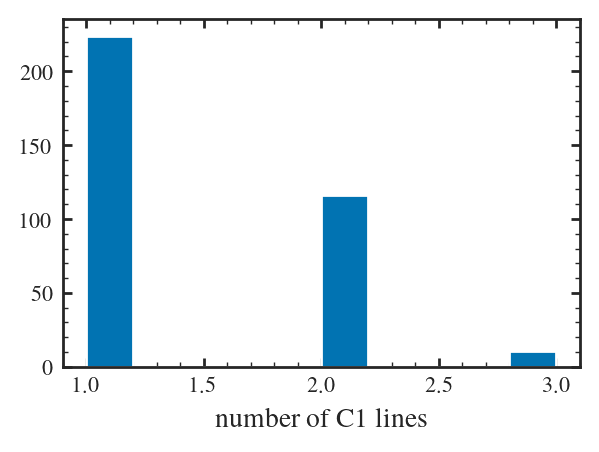

In [41]:
plt.hist(gso_good["NN_C1"][~pd.isna(gso_good["NN_C1"])])
plt.xlabel("number of C1 lines")

Text(0, 0.5, '[C/Mg]')

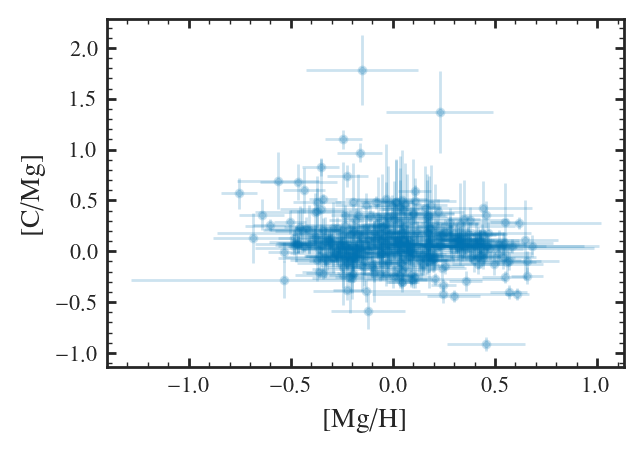

In [42]:
plt.errorbar(gso_good.MG_H, gso_good.C_MG, yerr=np.abs(gso_good.C_MG_ERR), xerr=gso_good.MG_H_ERR, fmt="o", alpha=0.2, capsize=0)

plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")


Text(0, 0.5, '[Mg/Fe]')

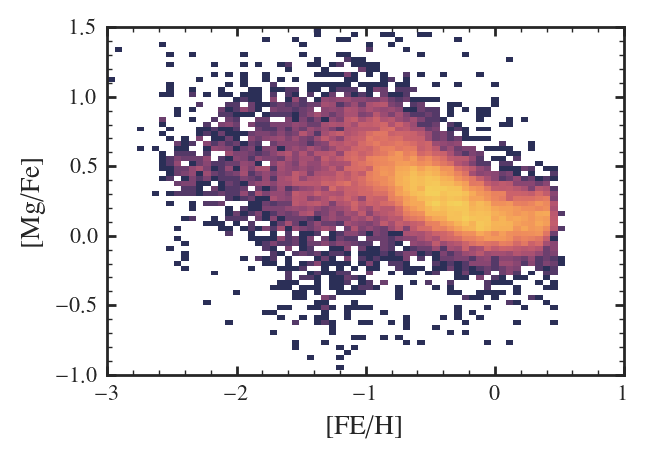

In [43]:
plt.hist2d(gaiaeso.FE_H, gaiaeso.MG_FE, 70, norm=mpl.colors.LogNorm(), range=[[-3, 1], [-1, 1.5]]);
plt.xlabel("[FE/H]")
plt.ylabel("[Mg/Fe]")

Looks okay, no bimodality

Text(0, 0.5, '[C/Mg]')

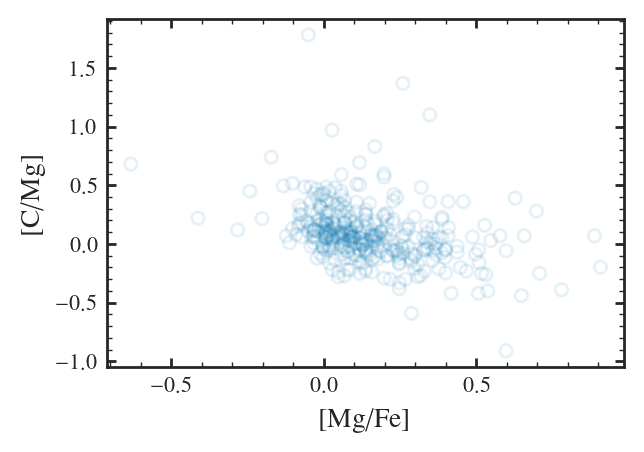

In [44]:
plt.scatter(gso_good.MG_FE, gso_good.C_MG, fc="none", ec=arya.COLORS[0], s=20, alpha=0.1)
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

In [45]:
gso[gso.C_MG_ERR > 0].to_csv("gso_dwarfs.csv")

In [46]:
print(np.sum(gso.C_MG_ERR > 0))

3675


# DESI MWM

Data access:https://data.desi.lbl.gov/doc/access/
Data Model: https://desi-mws-edr-datamodel.readthedocs.io/en/latest/

see below, likely not reliable for this kind of work...

In [ ]:
f_desi = fits.open(f"{data_dir}/mwsall-pix-fuji.fits", memmap=True)

In [ ]:
desi["PARAM"][1]

In [ ]:
f_desi[2].header

In [260]:
desi = Table.read(f"{data_dir}/mwsall-pix-fuji.fits", format="fits", hdu=2, memmap=True)
desi_rv = Table.read(f"{data_dir}/mwsall-pix-fuji.fits", format="fits", hdu=1, memmap=True)

desi["TEFF_ERR"] = desi["COVAR"][:, 2, 2]**0.5

desi["FEH_ERR"] = desi["COVAR"][:, 0, 0]**0.5
desi["ALPHAFE_ERR"] = desi["COVAR"][:, 1, 1]**0.5
desi["LOGG_ERR"] = desi["COVAR"][:, 4, 4]**0.5
desi["TEFF_ERR"] = desi["COVAR"][:, 3, 3]**0.5




# this is not well documented, just guessing here
desi["C_H"] = desi["ELEM"][:, 0]
desi["MG_H"] = desi["ELEM"][:, 1]
desi["CA_H"] = desi["ELEM"][:, 2]
desi["FE_H"] = desi["ELEM"][:, 3]


desi["C_H_ERR"] = desi["ELEM_ERR"][:, 0]
desi["MG_H_ERR"] = desi["ELEM_ERR"][:, 1]
desi["CA_H_ERR"] = desi["ELEM_ERR"][:, 3]
desi["FE_H_ERR"] = desi["ELEM_ERR"][:, 2]

desi["C_MG"] = desi["C_H"] - desi["MG_H"]
desi["MG_FE"] = desi["MG_H"] - desi["FE_H"]


# filter out the worst of it

filt = desi["LOGG"] > 1
filt &= desi["LOGG"] < 5
filt &= desi["TEFF"] > 2000
filt &= desi["TEFF"] < 10_000
filt &= desi["FEH_ERR"] < 0.1
filt &= desi["TEFF_ERR"] < 100
filt &= desi["LOGG_ERR"] < 0.3

filt &= desi["SUCCESS"] > 0

print(len(desi))
print(sum(filt))
desi_rv = desi_rv[filt]
desi = desi[filt]

/tmp/slurmtmp.28566167/ipykernel_227843/207334537.py:4: RuntimeWarning: invalid value encountered in sqrt
  desi["TEFF_ERR"] = desi["COVAR"][:, 2, 2]**0.5
/tmp/slurmtmp.28566167/ipykernel_227843/207334537.py:6: RuntimeWarning: invalid value encountered in sqrt
  desi["FEH_ERR"] = desi["COVAR"][:, 0, 0]**0.5
/tmp/slurmtmp.28566167/ipykernel_227843/207334537.py:7: RuntimeWarning: invalid value encountered in sqrt
  desi["ALPHAFE_ERR"] = desi["COVAR"][:, 1, 1]**0.5
/tmp/slurmtmp.28566167/ipykernel_227843/207334537.py:8: RuntimeWarning: invalid value encountered in sqrt
  desi["LOGG_ERR"] = desi["COVAR"][:, 4, 4]**0.5
/tmp/slurmtmp.28566167/ipykernel_227843/207334537.py:9: RuntimeWarning: invalid value encountered in sqrt
  desi["TEFF_ERR"] = desi["COVAR"][:, 3, 3]**0.5


625588
299621


Text(0, 0.5, 'log g')

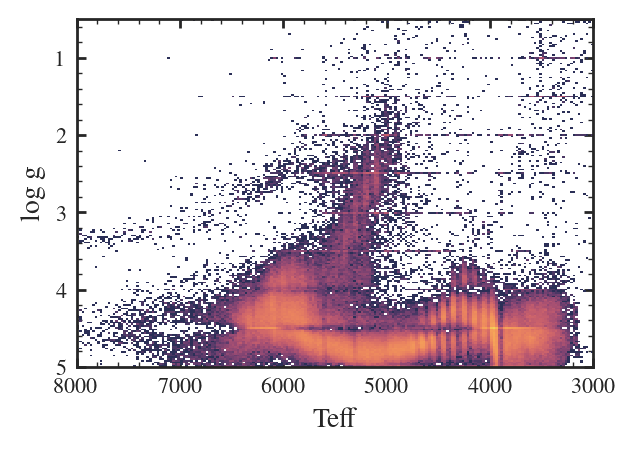

In [261]:
plt.hist2d(desi_rv["TEFF"], desi_rv["LOGG"],  200, 
           range=[[3000, 8000], [0.5, 5]], norm=mpl.colors.LogNorm())
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Teff")
plt.ylabel("log g")

Text(0, 0.5, 'log g')

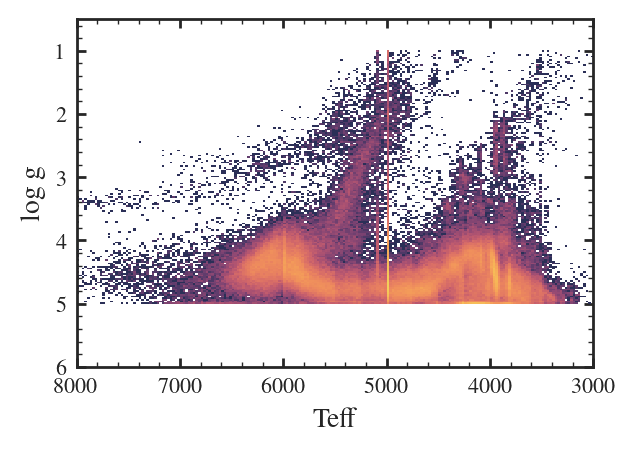

In [262]:
plt.hist2d(desi["TEFF"], desi["LOGG"],  200, 
           range=[[3000, 8000], [0.5, 6]], norm=mpl.colors.LogNorm())
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Teff")
plt.ylabel("log g")

Keil diagram looks like nonsense, not a good sign...

## Abundance validation

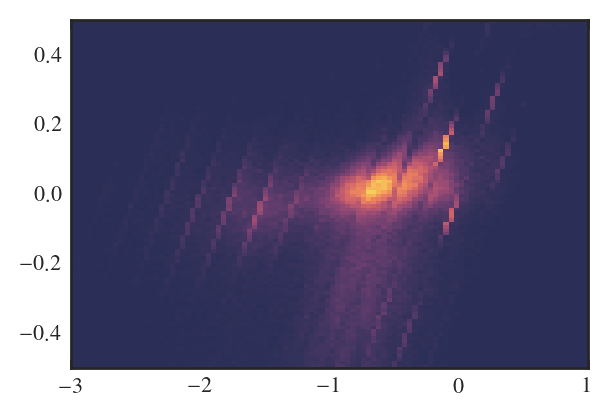

In [271]:
plt.hist2d(desi["FEH"], desi["FEH"] - desi_rv["FEH"], 100, range=((-3, 1), (-0.5, 0.5)), );

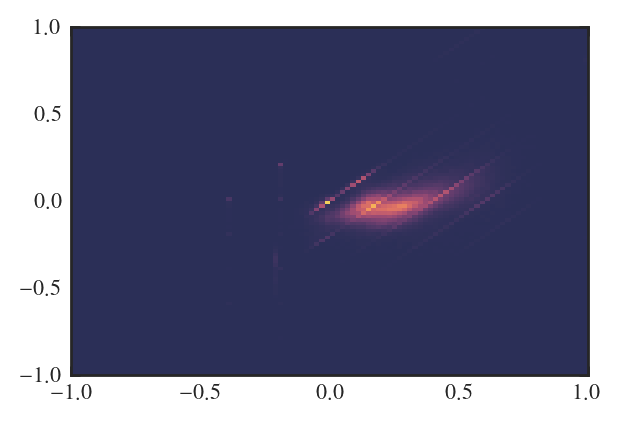

In [265]:
plt.hist2d(desi["ALPHAFE"], desi["ALPHAFE"] - desi_rv["ALPHAFE"], 100, range=((-1, 1), (-1, 1)), );

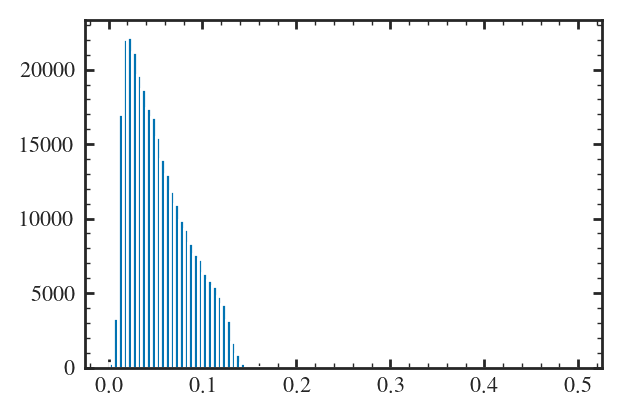

In [287]:
plt.hist(desi["ELEM_ERR"][:, 3], 100, range=(0, 0.5));

Fe errors (above) do not correspond with abundance versus stellar parameter errors.

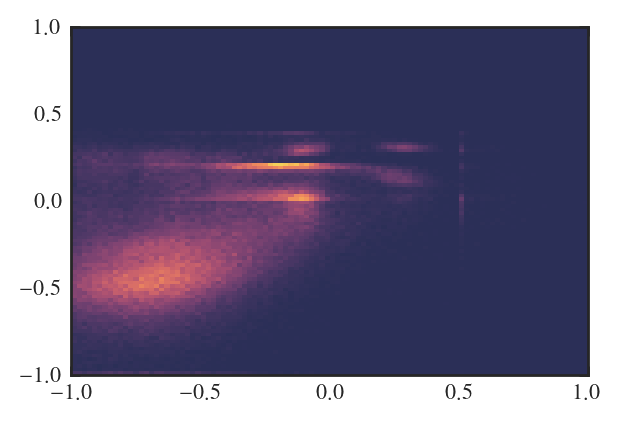

In [278]:
plt.hist2d(desi["FEH"], desi["FEH"] - desi["FE_H"], 100, range=((-1, 1), (-1, 1)), );

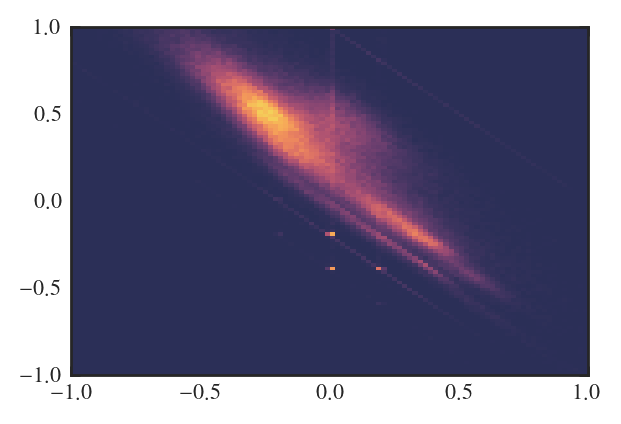

In [268]:
plt.hist2d(desi["MG_FE"], desi["ALPHAFE"] - desi["MG_FE"], 100, range=((-1, 1), (-1, 1)), );

## Plots

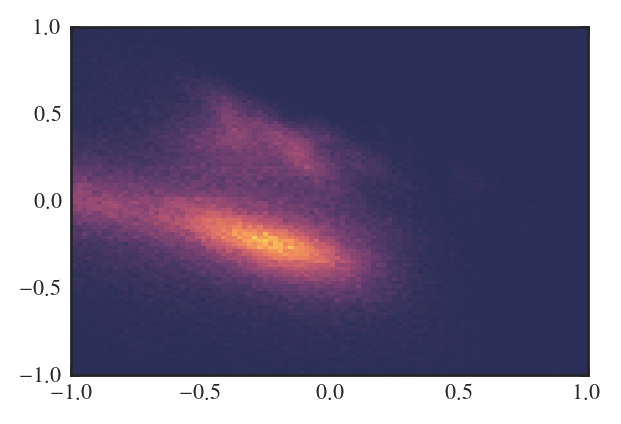

In [267]:
plt.hist2d(desi["FE_H"], desi["MG_FE"], 100, range=((-1, 1), (-1, 1)), );

almost looks believable

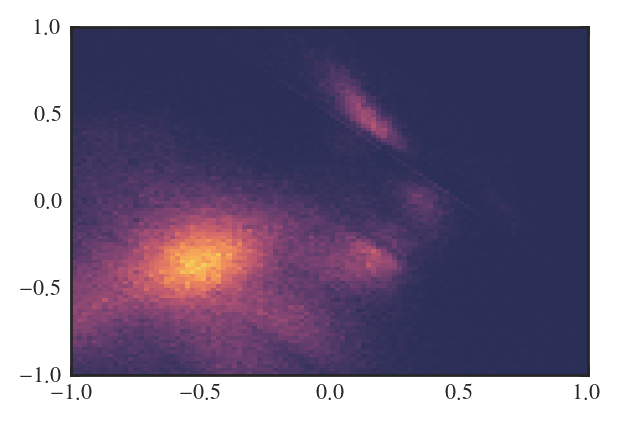

In [266]:
plt.hist2d(desi["MG_H"], desi["C_MG"], 100, range=((-1, 1), (-1, 1)), );

this one not so much

# Crossmathing

In [157]:
apogee = pd.read_csv(f"{data_dir}/apogee_most.csv")

In [158]:
apogee = apogee[1:]
apogee.reset_index()

,index,Unnamed: 0,FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,...,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,MG_H,C_H,N_H,C_MG,N_MG,high_alpha
0,1,1,b'apStar-dr17-2M00000002+7417074.fits',b'2M00000002+7417074',b'apo25m.120+12.2M00000002+7417074',b'apogee.apo25m.stars.120+12.2M00000002+7417074',b'apogee.apo25m.synspec_fix.120+12.2M00000002+...,b'apo25m',5046,b'120+12',...,NaN,NaN,1.0,2,-0.130251,-0.151385,-0.009460,-0.021134,0.120791,False
1,2,2,b'apStar-dr17-2M00000019-1924498.fits',b'2M00000019-1924498',b'apo25m.060-75.2M00000019-1924498',b'apogee.apo25m.stars.060-75.2M00000019-1924498',b'apogee.apo25m.synspec_fix.060-75.2M00000019-...,b'apo25m',5071,b'060-75',...,NaN,NaN,1.0,2,-0.110292,-0.213792,-0.387430,-0.103500,-0.277139,False
2,3,3,b'apStar-dr17-2M00000032+5737103.fits',b'2M00000032+5737103',b'apo25m.N7789.2M00000032+5737103',b'apogee.apo25m.stars.N7789.2M00000032+5737103',b'apogee.apo25m.synspec_fix.N7789.2M00000032+5...,b'apo25m',4264,b'N7789',...,NaN,NaN,1.0,2,-0.215265,-0.181519,-0.703230,0.033746,-0.487965,False
3,4,4,b'apStar-dr17-2M00000068+5710233.fits',b'2M00000068+5710233',b'apo25m.N7789.2M00000068+5710233',b'apogee.apo25m.stars.N7789.2M00000068+5710233',b'apogee.apo25m.synspec_fix.N7789.2M00000068+5...,b'apo25m',4264,b'N7789',...,NaN,NaN,1.0,2,-0.068220,-0.186011,-0.076104,-0.117791,-0.007884,False
4,5,5,b'apStar-dr17-2M00000233+1452324.fits',b'2M00000233+1452324',b'apo25m.105-45.2M00000233+1452324',b'apogee.apo25m.stars.105-45.2M00000233+1452324',b'apogee.apo25m.synspec_fix.105-45.2M00000233+...,b'apo25m',4548,b'105-45',...,NaN,NaN,1.0,2,0.364261,0.384011,0.438260,0.019750,0.073999,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206683,206684,206684,b'apStar-dr17-2M23595606+6251121.fits',b'2M23595606+6251121',b'apo25m.116+00.2M23595606+6251121',b'apogee.apo25m.stars.116+00.2M23595606+6251121',b'apogee.apo25m.synspec_fix.116+00.2M23595606+...,b'apo25m',5045,b'116+00',...,NaN,NaN,1.0,2,-0.021937,-0.139941,0.122656,-0.118004,0.144593,False
206684,206685,206685,b'apStar-dr17-2M23595676+7918072.fits',b'2M23595676+7918072',b'apo25m.120+18.2M23595676+7918072',b'apogee.apo25m.stars.120+18.2M23595676+7918072',b'apogee.apo25m.synspec_fix.120+18.2M23595676+...,b'apo25m',5047,b'120+18',...,NaN,NaN,1.0,2,-0.207697,-0.410099,-0.352190,-0.202402,-0.144493,True
206685,206686,206686,b'apStar-dr17-2M23595756+8535275.fits',b'2M23595756+8535275',b'apo25m.N188.2M23595756+8535275',b'apogee.apo25m.stars.N188.2M23595756+8535275',b'apogee.apo25m.synspec_fix.N188.2M23595756+85...,b'apo25m',5067,b'N188',...,NaN,NaN,1.0,2,0.180528,0.182211,0.370650,0.001683,0.190121,False
206686,206687,206687,b'apStar-dr17-2M23595886+5726058.fits',b'2M23595886+5726058',b'apo25m.116-04.2M23595886+5726058',b'apogee.apo25m.stars.116-04.2M23595886+5726058',b'apogee.apo25m.synspec_fix.116-04.2M23595886+...,b'apo25m',4424,b'116-04',...,NaN,NaN,1.0,2,-0.153028,-0.296874,-0.034680,-0.143846,0.118348,False


In [160]:
def crossmatch_test(df1, df2, col, s=1, alpha=0.1, **kwargs):
    x1 = np.array(df1[col])
    x2 = np.array(df2[col])
    plt.scatter(x1, x2-x1, s=s, alpha=alpha, **kwargs)
    plt.axhline(0, c="k")
    plt.xlabel(col.replace("_", "/"))
    plt.ylabel("delta " + col.replace("_", "/"))

In [161]:
def crossmatch_test_hist(df1, df2, col, bins=100, norm="log", s=1, alpha=0.1, range=None, **kwargs):
    x1 = np.array(df1[col])
    x2 = np.array(df2[col])
    if range is None:
        range = ((np.nanmin(x1), np.nanmax(x1)), (-1, 1))
    plt.hist2d(x1, x2-x1, bins, range=range, norm=norm, **kwargs)
    plt.axhline(0, c="k")
    plt.xlabel(col.replace("_", "/"))
    plt.ylabel("delta " + col.replace("_", "/"))
    plt.colorbar(label="count")

## GALAH - APOGEE

In [179]:
from surp import subgiants
from astropy.coordinates import SkyCoord
from astropy import units as u


In [194]:
def get_crossmatch(ra1, dec1, ra2, dec2, max_sep=1*u.arcsec):
    ra1 = np.array(ra1)
    dec1 = np.array(dec1)
    ra2 = np.array(ra2)
    dec2 = np.array(dec2)
    
    # Convert catalogue positions into SkyCoord objects
    coords1 = SkyCoord(ra=ra1 * u.degree, dec=dec1 * u.degree)
    coords2 = SkyCoord(ra=ra2 * u.degree, dec=dec2 * u.degree)

    # Perform crossmatch
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    sep_constraint = d2d < max_sep

    # Filter matches
    matches = idx[sep_constraint]
    matched_d2d = d2d[sep_constraint]


    idx_l = np.where(sep_constraint)[0] #df indicies
    idx_r = matches # apogee indicies

    print(len(ra1))
    print(len(ra2))
    print(len(idx_l))
    
    plt.scatter(ra2, dec2,  s=0.01, alpha=1, label="2")

    plt.scatter(ra1, dec1,  s=0.01, alpha=1, label="1")
    plt.xlabel("RA")
    plt.ylabel("DEC")
    plt.show()
    
    plt.scatter(ra2[idx_r], dec2[idx_r], 
                s=0.01, alpha=1, label="match")
    plt.scatter(ra1[idx_l], dec1[idx_l],
                s=0.01, alpha=1, label="match")
    plt.xlabel("RA")
    plt.ylabel("DEC")
    
    return idx_l, idx_r

323420
206688
6594


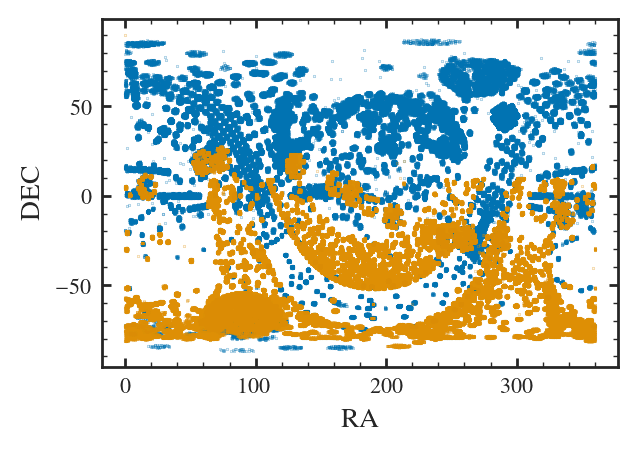

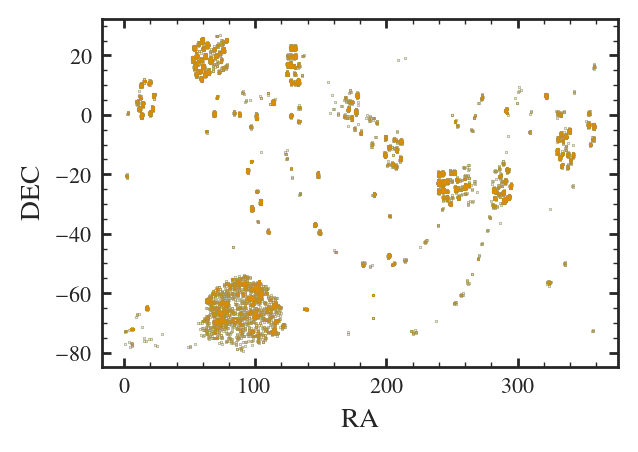

In [195]:
idx_l, idx_r = get_crossmatch(galah.ra_dr2, galah.dec_dr2, apogee.RA, apogee.DEC)

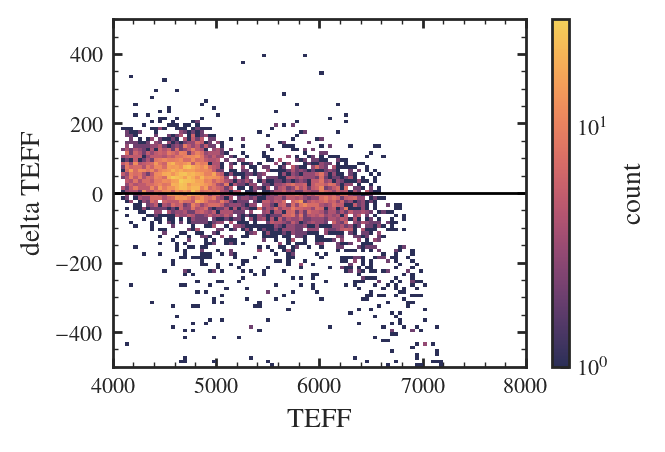

In [196]:
crossmatch_test_hist(galah.iloc[idx_l], apogee.iloc[idx_r],  "TEFF", range=((4000, 8000), (-500, 500)),)

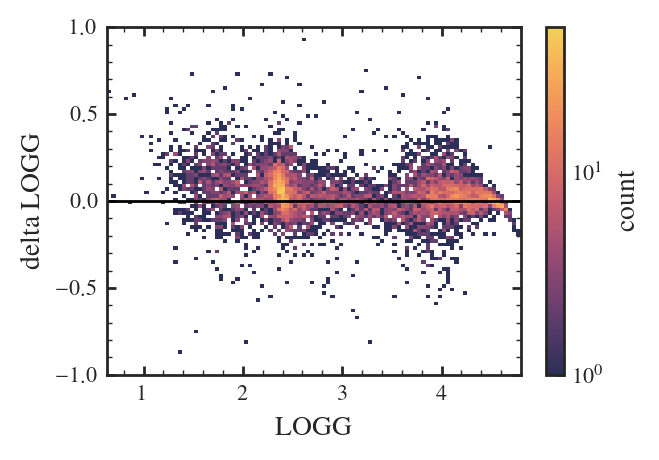

In [197]:
crossmatch_test_hist(galah.iloc[idx_l], apogee.iloc[idx_r], "LOGG")

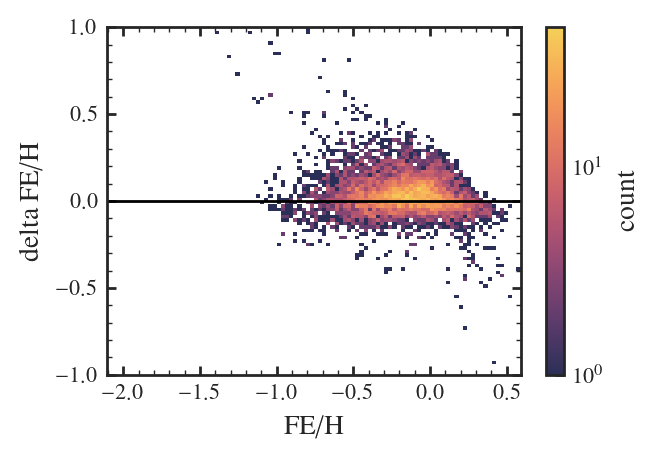

In [198]:
crossmatch_test_hist(galah.iloc[idx_l], apogee.iloc[idx_r], "FE_H", bins=100, norm="log")

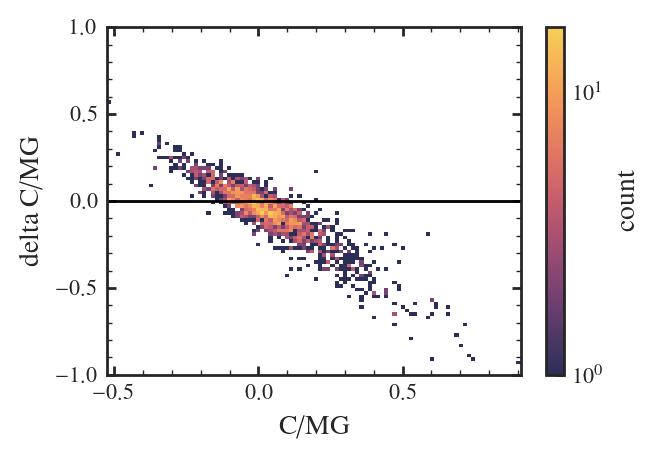

In [199]:
crossmatch_test_hist(galah.iloc[idx_l], apogee.iloc[idx_r], "C_MG", bins=100, norm="log")

(-0.5, 1.0422286033630375)

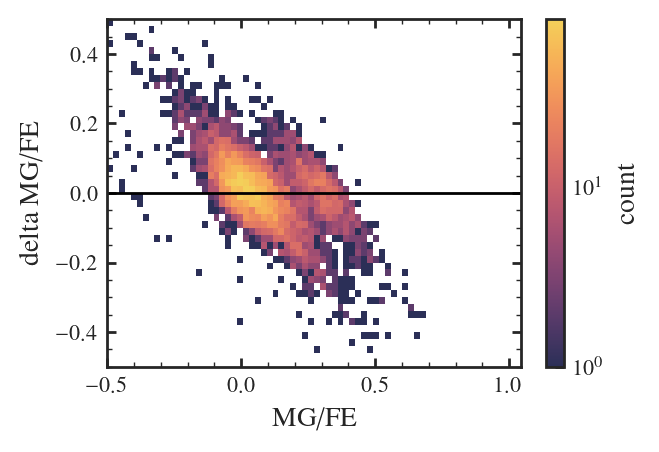

In [200]:
crossmatch_test_hist(galah.iloc[idx_l], apogee.iloc[idx_r], "MG_FE")
plt.ylim(-0.5, 0.5)
plt.xlim(-0.5)

In [201]:
len(apogee)

206688

In [202]:
len(subgiants)

16365

# Crossmatch GaiaESO

52385
206688
50


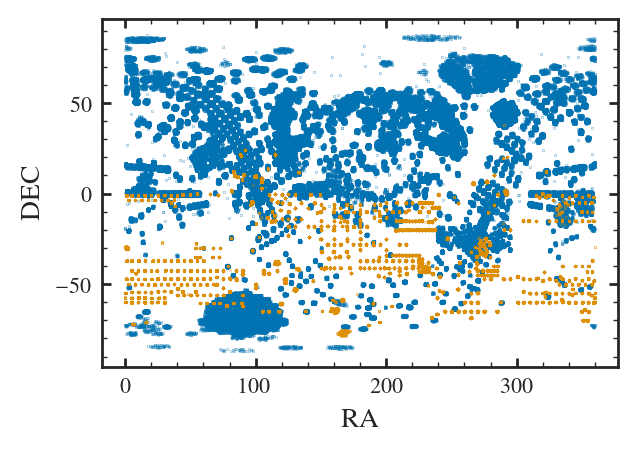

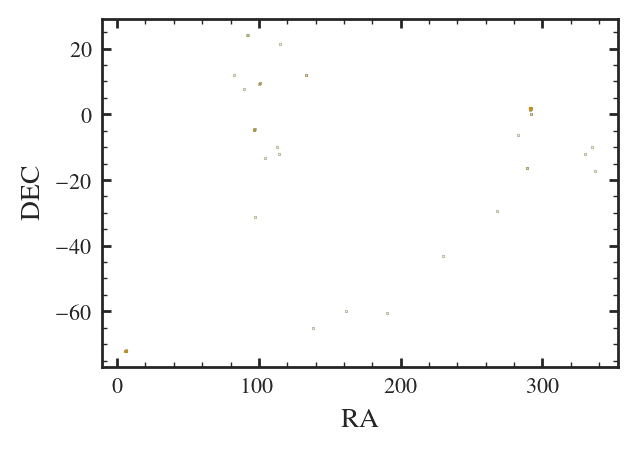

In [208]:
idx_l, idx_r = get_crossmatch(gaiaeso.RA, gaiaeso.DECLINATION, apogee.RA, apogee.DEC, max_sep=10*u.arcsec)


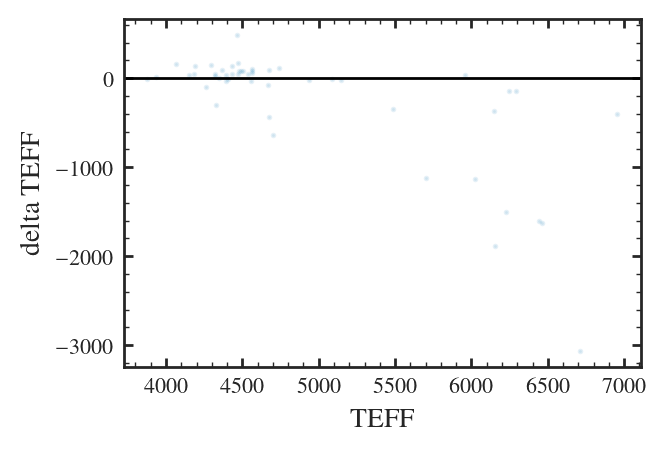

In [210]:
crossmatch_test(gaiaeso.iloc[idx_l], apogee.iloc[idx_r],  "TEFF")

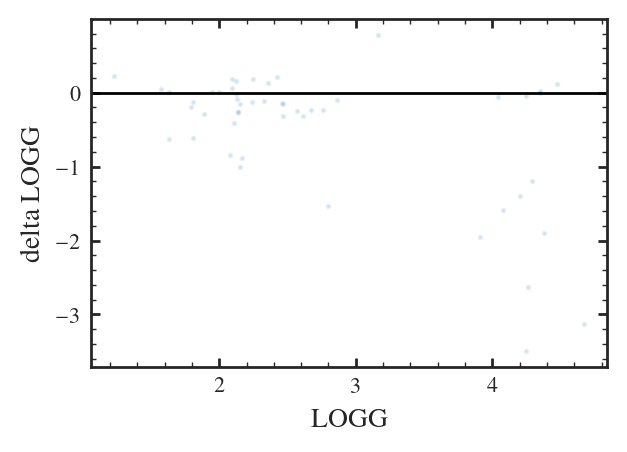

In [212]:
crossmatch_test(gaiaeso.iloc[idx_l], apogee.iloc[idx_r],  "LOGG")

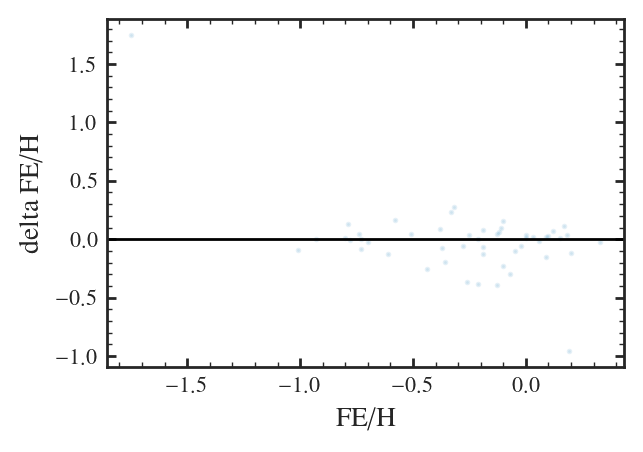

In [213]:
crossmatch_test(gaiaeso.iloc[idx_l], apogee.iloc[idx_r],  "FE_H")

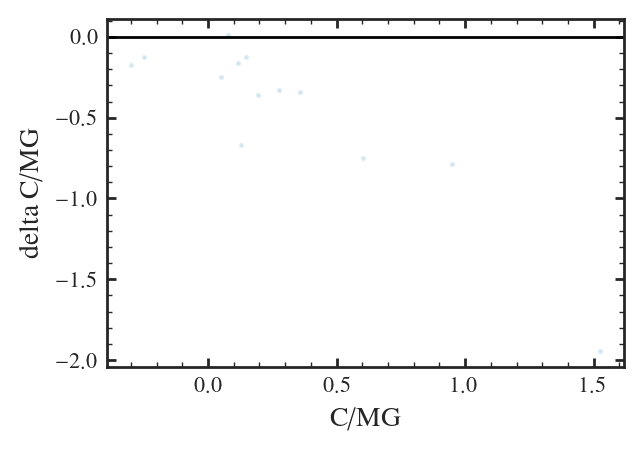

In [214]:
crossmatch_test(gaiaeso.iloc[idx_l], apogee.iloc[idx_r],  "C_MG")

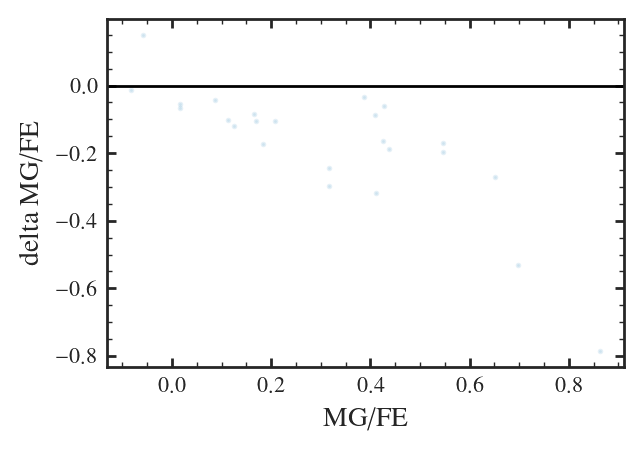

In [215]:
crossmatch_test(gaiaeso.iloc[idx_l], apogee.iloc[idx_r],  "MG_FE")

## galah - gaiaeso

52385
323420
159


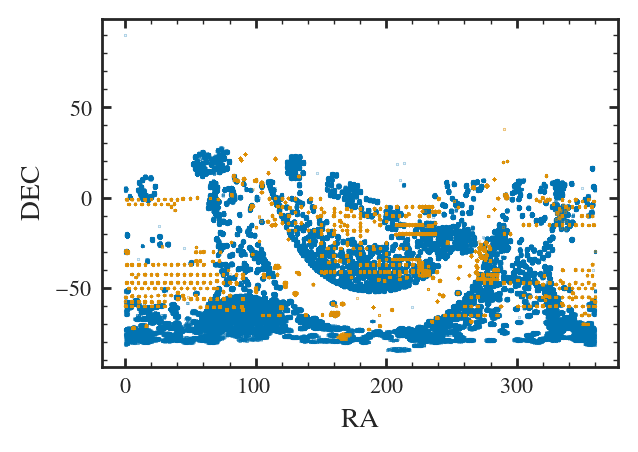

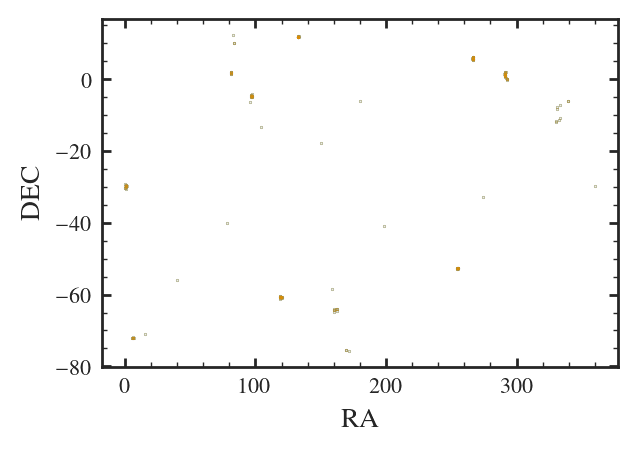

In [217]:
idx_l, idx_r = get_crossmatch(gaiaeso.RA, gaiaeso.DECLINATION, galah.ra_dr2, galah.dec_dr2, max_sep=1*u.arcsec)


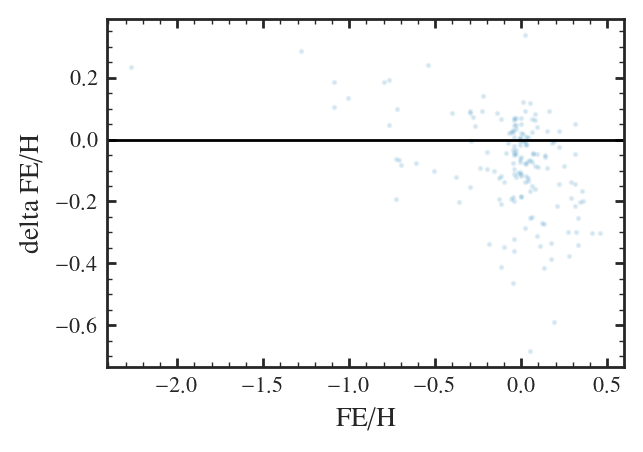

In [218]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "FE_H")

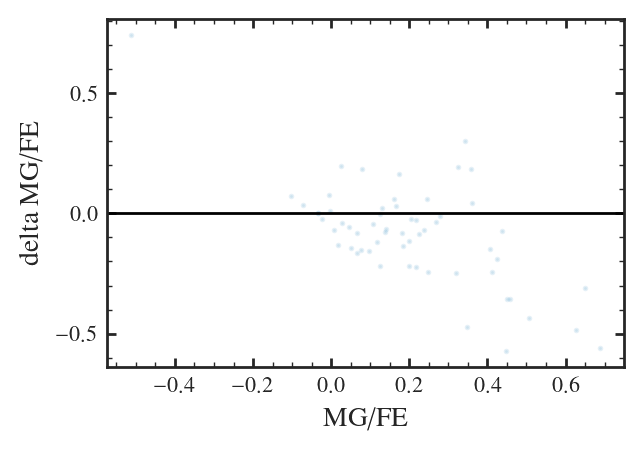

In [219]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "MG_FE")

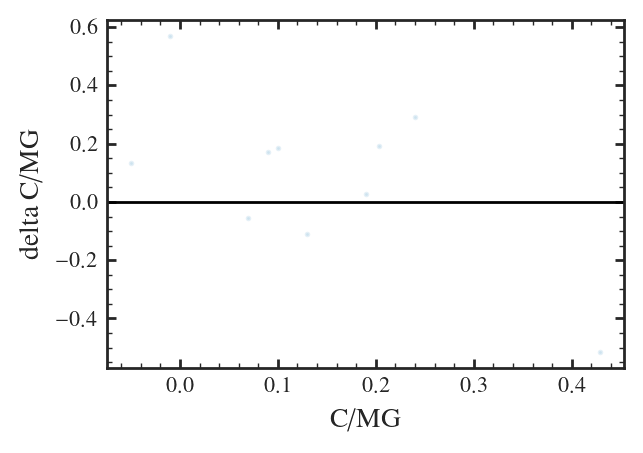

In [220]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "C_MG")

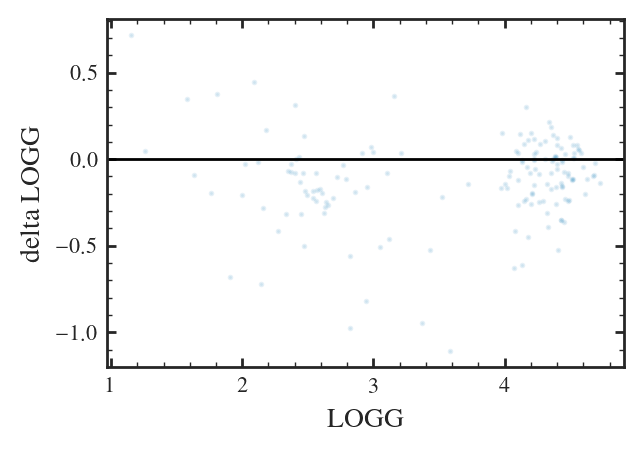

In [221]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "LOGG")

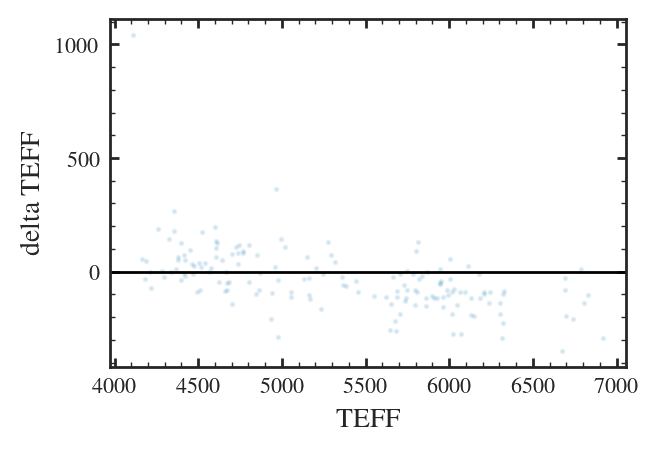

In [222]:
crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], "TEFF")